In [2]:
# ✅ Install necessary libraries
!pip install torchaudio librosa transformers phonemizer jiwer
!apt-get update && apt-get install -y espeak  # Install espeak for the 'espeak' backend

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 257 kB in 1s (201 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package list

Saving output (1).wav to output (1) (1).wav


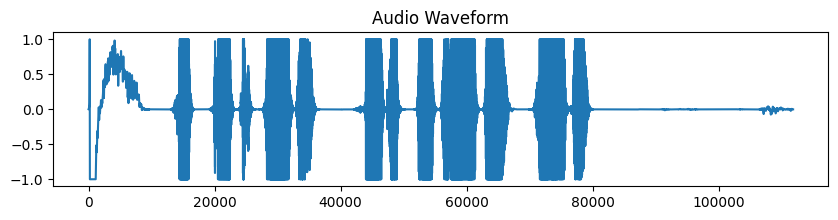

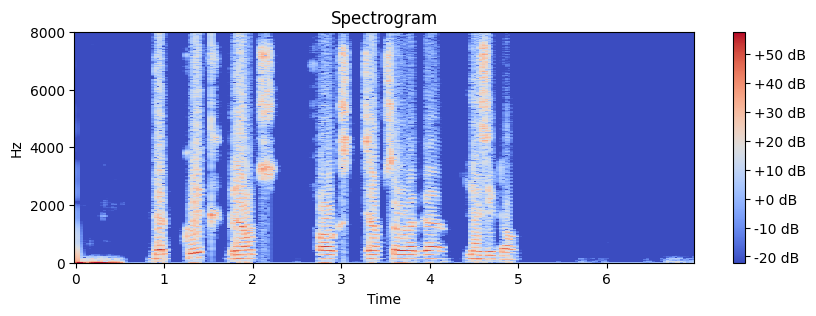

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🗣️ Transcription: THE QUICK BLOUNCS FOXS JUMPS OVER THE LIZZIE DOG

📌 Reference Phonemes:
 ðə kwɪk bɹaʊn fɑːks dʒʌmps oʊvɚ ðə leɪzi dɑːɡ
🗣️ Spoken Phonemes:
 ðə kwɪk blaʊŋks fɑːksz dʒʌmps oʊvɚ ðə lɪzi dɑːɡ

📈 Phoneme Comparison:
 ðə ⟶ ðə  ✔️
kwɪk ⟶ kwɪk ✔️
bɹaʊn ⟶ blaʊŋks ❌
fɑːks ⟶ fɑːksz ❌
dʒʌmps ⟶ dʒʌmps ✔️
oʊvɚ ⟶ oʊvɚ ✔️
 ðə ⟶ ðə  ✔️
leɪzi ⟶ lɪzi ❌
dɑːɡ ⟶ dɑːɡ ✔️

🎯 Pronunciation Accuracy: 66.67%


In [5]:

# ✅ Upload Audio File
from google.colab import files
uploaded = files.upload()
filename = next(iter(uploaded))

# ✅ Load and Transcribe using Wav2Vec2
import torchaudio, torch
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import librosa.display
import matplotlib.pyplot as plt
from phonemizer import phonemize
import difflib
import numpy as np
from termcolor import colored  # For color-coded feedback

waveform, sample_rate = torchaudio.load(filename)

# Plot waveform for visual feedback
plt.figure(figsize=(10, 2))
plt.plot(waveform.t().numpy())
plt.title("Audio Waveform")
plt.show()

# Plot spectrogram
plt.figure(figsize=(10, 3))
spec = librosa.stft(waveform[0].numpy())
spec_db = librosa.amplitude_to_db(abs(spec))
librosa.display.specshow(spec_db, sr=sample_rate, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

# Transcription using Wav2Vec2
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
input_values = processor(waveform.squeeze(), return_tensors="pt", sampling_rate=sample_rate).input_values
with torch.no_grad():
    logits = model(input_values).logits
transcription = processor.decode(torch.argmax(logits, dim=-1)[0])
print(f"\n🗣️ Transcription: {transcription}")

# ✅ Phoneme Conversion
reference_sentence = "The quick brown fox jumps over the lazy dog"
reference_phonemes = phonemize(reference_sentence, language='en-us', backend='espeak', strip=True)
spoken_phonemes = phonemize(transcription, language='en-us', backend='espeak', strip=True)
print("\n📌 Reference Phonemes:\n", reference_phonemes)
print("🗣️ Spoken Phonemes:\n", spoken_phonemes)

# ✅ Compare Phonemes with color-coded feedback and accuracy score
print("\n📈 Phoneme Comparison:")
def compare_phonemes(ref, hyp):
    ref_list, hyp_list = ref.split(), hyp.split()
    matcher = difflib.SequenceMatcher(None, ref_list, hyp_list)
    total, correct = 0, 0
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        for r, h in zip(ref_list[i1:i2], hyp_list[j1:j2]):
            total += 1
            if r == h:
                correct += 1
                print(colored(f"{r:>3} ⟶ {h:<3} ✔️", 'green'))
            else:
                print(colored(f"{r:>3} ⟶ {h:<3} ❌", 'red'))
    accuracy = (correct / total) * 100 if total > 0 else 0
    print(f"\n🎯 Pronunciation Accuracy: {accuracy:.2f}%")

compare_phonemes(reference_phonemes, spoken_phonemes)
